<a href="https://colab.research.google.com/github/Athulya2/crop-and-weed-detection/blob/main/ssd_Algorithm_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
print(tf.__version__)


2.8.2


In [ ]:
!pip install tf-models-official==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 30.2 MB/s 
     |████████████████████████████████| 636 kB 62.3 MB/s 
     |████████████████████████████████| 4.9 MB 58.7 MB/s 
     |████████████████████████████████| 1.2 MB 71.9 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 237 kB 48.4 MB/s 
     |████████████████████████████████| 352 kB 10.1 MB/s 
     |████████████████████████████████| 1.1 MB 54.8 MB/s 
     |████████████████████████████████| 99 kB 10.8 MB/s 
     |████████████████████████████████| 92 kB 12.4 MB/s 
     |████████████████████████████████| 48.3 MB 80.8 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=7a58f4188ceea30477a6b6fbfa540dc29e013cdc9f614093961666f948d3584d
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
 

In [ ]:
%cd /content/drive/MyDrive/customTF2/data

/content/drive/MyDrive/customTF2/data


In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[5][0].text),
                     int(member[5][1].text),
                     int(member[5][2].text),
                     int(member[5][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height' ,'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = '/content/drive/MyDrive/customTF2/data/test_labels'
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('test_labels.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


In [ ]:
!pip install tensorflow-object-detection-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 577 kB 4.7 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 48 kB 2.3 MB/s 
     |████████████████████████████████| 4.0 MB 39.7 MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844512 sha256=556bbe2b0096abfee39c8ea09fc0aa72bf57f4e575553862036c3d9715beee80
  Stored in directory: /root/.cache/pip/wheels/71/7e/a2/461ab817fbaef68ec9cc60df16d3669d1285f032e4c98179bf
Successfully built tensorflow-object-detection-api


In [ ]:
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record
  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow.compat.v1 as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
#flags.DEFINE_string('csv_input', '', '/content/raccoon_labels5.csv')
#flags.DEFINE_string('output_path', '', '')
#flags.DEFINE_string('image_dir', '', '/content/sample_data/images')
#FLAGS = flags.FLAGS


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'crop':
        return 1
    elif row_label == 'weed':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter('/content/drive/MyDrive/customTF2/data/train.record')
    path = os.path.join('/content/drive/MyDrive/customTF2/data/images')
    examples = pd.read_csv('/content/drive/MyDrive/customTF2/data/train_labels.csv')
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/customTF2/data/train.record' )
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()

Successfully created the TFRecords: /content/drive/MyDrive/customTF2/data/train.record


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%cd /content/

/content


In [ ]:
# clone the tensorflow models on the colab cloud vm
!git clone --q https://github.com/tensorflow/models.git

#navigate to /models/research folder to compile protos
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 8.1 MB/s 
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 508 kB 56.8 MB/s 
     |████████████████████████████████| 272 kB 55.0 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 2.3 

In [ ]:
# testing the model builder
!python object_detection/builders/model_builder_tf2_test.py

2022-07-01 11:26:26.967572: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0701 11:26:27.805694 139741022320512 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.78s
I0701 11:26:28.755523 139741022320512 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.78s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 1.35s
I0701 11:26:30.109982 139741022320512 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_cr

In [ ]:
#navigate to /models/research folder to compile protos
%cd /content/sample_data/training

/content/sample_data/training


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

--2022-07-01 11:27:23--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.1.128, 2607:f8b0:4001:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.1.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2022-07-01 11:27:23 (196 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/c

In [ ]:
%load_ext tensorboard         
%tensorboard --logdir '/content/sample_data/training'

In [ ]:
%cd /content/models/research/object_detection

/content/models/research/object_detection


In [ ]:
!pip list|grep opencv

opencv-contrib-python           4.1.2.30
opencv-python                   4.1.2.30
opencv-python-headless          4.6.0.66


In [ ]:
!pip uninstall opencv-python-headless --y

!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.5 MB/s 


In [ ]:
!python model_main_tf2.py --pipeline_config_path=/content/sample_data/training/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/content/sample_data/training --alsologtostderr

2022-07-01 12:09:20.283816: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W0701 12:09:20.289175 140706893723520 cross_device_ops.py:1386] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0701 12:09:20.300093 140706893723520 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0701 12:09:20.305526 140706893723520 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0701 12:09:20.305728 140706893723520 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0701 12:09:20.493649 140706893723520 deprecation.py:343] From /usr/local/

In [ ]:
!python model_main_tf2.py --pipeline_config_path=/content/sample_data/training/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --model_dir=/content/sample_data/training --checkpoint_dir=/content/sample_data/training --alsologtostderr

Traceback (most recent call last):
  File "model_main_tf2.py", line 30, in <module>
    import tensorflow.compat.v2 as tf
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/__init__.py", line 473, in <module>
    keras._load()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/lazy_loader.py", line 41, in _load
    module = importlib.import_module(self.__name__)
  File "/usr/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "/usr/local/lib/python3.7/dist-packages/keras/api/__init__.py", line 8, in <module>
    from keras.api import keras
  File "/usr/local/lib/python3.7/dist-packages/keras/api/keras/__init__.py", line 17, in <module>
    from keras.api.keras import experimental
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _lo

In [ ]:
!python exporter_main_v2.py --trained_checkpoint_dir=/content/sample_data/training --pipeline_config_path=/content/sample_data/training/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config --output_directory /content/sample_data/training/inference_graph

2022-06-23 08:18:11.538556: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0623 08:18:11.672945 139652118771584 deprecation.py:615] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
2022-06-23 08:18:26.289080: W ten

In [ ]:
# Different font-type for labels text.(This step is optional)
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .

%cd utils/
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 50)/" visualization_utils.py
%cd ..

--2022-06-15 12:53:50--  https://freefontsdownload.net/download/160187/arial.zip
Resolving freefontsdownload.net (freefontsdownload.net)... 104.21.75.182, 172.67.180.27, 2606:4700:3036::6815:4bb6, ...
Connecting to freefontsdownload.net (freefontsdownload.net)|104.21.75.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172804 (169K) [application/force-download]
Saving to: ‘arial.zip’

arial.zip           100%[===================>] 168.75K  --.-KB/s    in 0.05s   

2022-06-15 12:53:51 (3.17 MB/s) - ‘arial.zip’ saved [172804/172804]

Archive:  arial.zip
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@#################################@
@#        Downloaded from        #@
@#                               #@
@#   www.FreeFontsDownload.net   #@
@#                               #@
@# ---------- More site -------- #@
@#      https://funnytv.net      #@
@#                               #@
@#                               #@
@#################################@
@@@@@@@@@@@@@@@@@@

Loading model...Done!


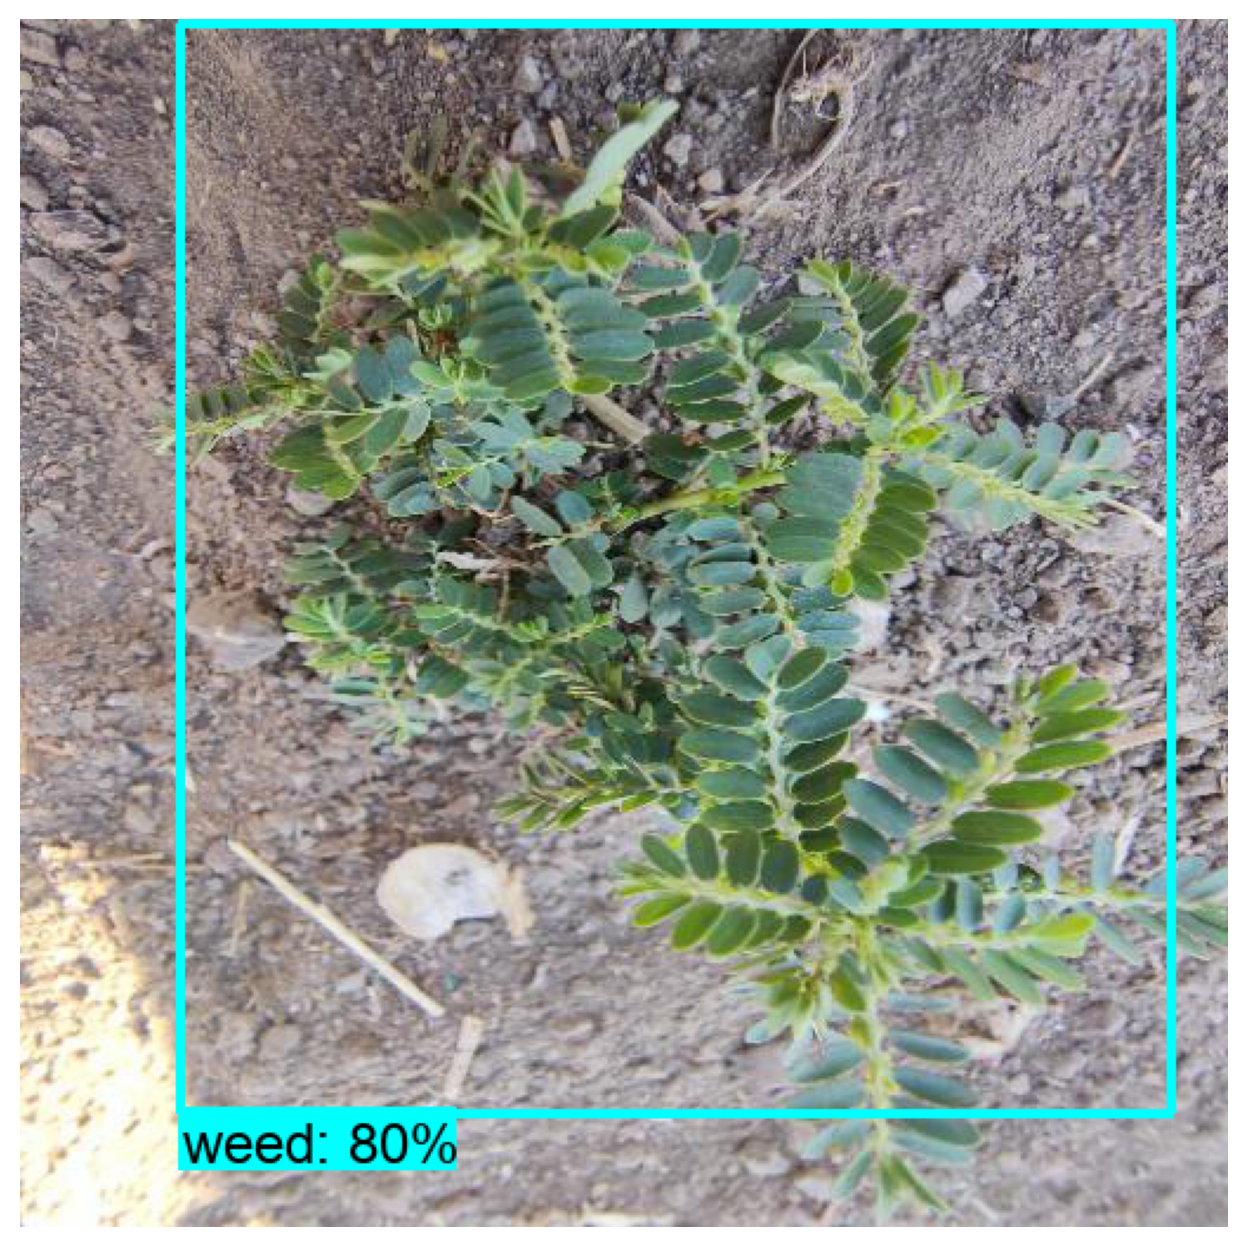

In [ ]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/content/sample_data/training/inference_graph/saved_model"
print('Loading model...', end='')

# Load saved model and build the detection function
detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

#Loading the label_map
category_index=label_map_util.create_category_index_from_labelmap("/content/drive/MyDrive/customTF2/data/object-detect.pbtxt",use_display_name=True)
#category_index=label_map_util.create_category_index_from_labelmap([path_to_label_map],use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

image_path = "/content/drive/MyDrive/Agriculture1/weed_1.jpeg"
#print('Running inference for {}... '.format(image_path), end='')

image_np = load_image_into_numpy_array(image_path)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()